## Instructions
- Import raw photon data from the results of 140 MeV/u Geant4 simulations with Z=29, Z=32, and Z=34
    - add the dataframes together
- Randomly generate 10 instances of 1 PMT signal missing
- Randomly generate 10 instances of 2 PMT signals missing
- Randomly generate 10 instances of 4 PMT signals missing
- Randomly generate 10 instances of 8 PMT signals missing

- Populate missing PMT signals with average of neighbors
- Populate missing PMT signals with the opposite side's PMT signal
- Populate missing PMT signals by fitting light distribution with Gaussian and interpolate the missing PMT signal

In [2]:
#-----------------Imports----------------------#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from scipy.optimize import curve_fit
import math

pd.set_option('display.max_columns', None)

#----Change to main ELOSS directory
os.chdir('C:\\Users\\dziubins\\Home\\Research\\Energy Loss Optical Scintillation System\\')


In [3]:
#----------------Functions---------------------#
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))

def find_dead_pmts(deaddf):
    detected = []
    dead_PMTs = []
    for column in deaddf.columns:
        if (deaddf[column] == 0).any():
            detected.append(column)
        # Find physical location of dead PMT
            mask = mapdf['Photon Column'] == detected[-1]
            dead_PMT = mapdf.loc[mask,'PMT Location'].values[0]
            dead_PMTs.append(dead_PMT)
            print("Missing PMT located at ", dead_PMT)
    print("________________________________________________________________________")
    print("*Note* Dead_pmts corresponds to column name --> index is column name - 1")
    return detected, dead_PMTs

def get_neighbors(PMT_Loc): # PMT_Loc is column name
    mask1 = mapdf['Photon Column'] == PMT_Loc-1
    mask2 = mapdf['Photon Column'] == PMT_Loc+1
    PMT1 = mapdf.loc[mask1,'PMT Location'].values[0]
    PMT2 = mapdf.loc[mask2,'PMT Location'].values[0]
    neighbors = [PMT1,PMT2]
    print("Neighboring PMTs are ", PMT1 ," and ", PMT2)
    return neighbors

def get_array(PMT_Loc):
    # What are the locations of all other PMTs in this array?
    sector = 'S' + PMT_Loc[1]
    array_pmts = []
    indices = []
    for pmt in range(120):
        if sector in mapdf['PMT Location'][pmt] and PMT_Loc[3] in mapdf['PMT Location'][pmt]:
            array_pmts.append(mapdf['PMT Location'][pmt])
            # What is the PMT designator for each of those PMTs?
            designator = mapdf['Photon Column'][mapdf['PMT Location'] == array_pmts[-1]].values[0]
            if array_pmts[-1] == PMT_Loc:
                desy = designator
                print("Designator of dead PMT: ", desy)
            indices.append(designator-1)
    print("PMTs in the same array: ", array_pmts)
    print("Indices for PMTs: ", indices)
    return array_pmts, indices, desy


In [4]:
#-------------Read in Photon Files---------------#
col_names = list(range(1,121,1))
folder = 'Work\\'

# Ion=As Z=33 A=81 Q=33 Energy=140 MeV/u
phodf33 = pd.read_table(folder+"new_r8520.photon", sep=' ', names=col_names, index_col=False )

# Ion=Br Z=35 A=83 Q=35 Energy=140 MeV/u
phodf35 = pd.read_table(folder+"r8520_Z35.photon", sep=' ', names=col_names, index_col=False )

# Ion=Ni Z=28 A=58 Q=28 Energy=140 MeV/u
phodf28 = pd.read_table(folder+"r8520_Z28.photon", sep=' ', names=col_names, index_col=False )

phodf = pd.concat([phodf28, phodf33, phodf35], ignore_index=True)

#-------------Read in PMT Mapping File---------------#
mapdf = pd.read_excel("Data\\ELOSS Channel Mapping.xlsx", sheet_name=[0], usecols="J:K", skiprows=[0,1], nrows=120)
mapdf = mapdf[0].sort_values(by=['PMT Location'])

In [5]:
#-------------Map PMT # to Location---------------#

#Sector 1 ==== 1->30
    #Left 1->10
    #Bottom 11->15
    #Right 16->25
    #Top 26->30
#Sector 2 ==== 31->60
    #Left 31->40
    #Bottom 41->45
    #Right 46->55
    #Top 56->60
#Sector 3 ==== 61->90
    #Left 61->70
    #Bottom 71->75
    #Right 76->85
    #Top 86->90
#Sector 4 ==== 91->120
    #Left 91->100
    #Bottom 101->105
    #Right 106->115
    #Top 116->120

mapdf['Photon Column'] = [11, 12, 13, 14, 15,
                          1, 10, 2, 3, 4, 5, 6, 7, 8, 9,
                          16, 25, 17, 18, 19, 20, 21, 22, 23, 24,
                          26, 27, 28, 29, 30,
                          11+30, 12+30, 13+30, 14+30, 15+30,
                          1+30, 10+30, 2+30, 3+30, 4+30, 5+30, 6+30, 7+30, 8+30, 9+30,
                          16+30, 25+30, 17+30, 18+30, 19+30, 20+30, 21+30, 22+30, 23+30, 24+30,
                          26+30, 27+30, 28+30, 29+30, 30+30,
                          11+60, 12+60, 13+60, 14+60, 15+60,
                          1+60, 10+60, 2+60, 3+60, 4+60, 5+60, 6+60, 7+60, 8+60, 9+60,
                          16+60, 25+60, 17+60, 18+60, 19+60, 20+60, 21+60, 22+60, 23+60, 24+60,
                          26+60, 27+60, 28+60, 29+60, 30+60,
                          11+90, 12+90, 13+90, 14+90, 15+90,
                          1+90, 10+90, 2+90, 3+90, 4+90, 5+90, 6+90, 7+90, 8+90, 9+90,
                          16+90, 25+90, 17+90, 18+90, 19+90, 20+90, 21+90, 22+90, 23+90, 24+90,
                          26+90, 27+90, 28+90, 29+90, 30+90]

In [90]:
#-------------Missing PMT Effect---------------#

# Make a copy
deaddf = phodf.copy()

# Kill user-determined number of PMTs in random locations
dead = 4
dead_pmts = np.random.randint(0,120,dead)
for d in dead_pmts:
    deaddf.iloc[:,d] = np.zeros(len(deaddf))

print("First Sector")
deaddf.iloc[:5,:30]

First Sector


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,88,108,151,199,289,387,507,629,695,751,244,495,1039,2240,3298,3833,4222,1381,514,245,132,82,53,31,0.0,233,208,193,0.0,176
1,871,2519,4664,2117,792,341,187,104,52,49,254,265,271,251,205,136,184,208,329,437,563,689,723,698,0.0,412,736,1195,0.0,1507
2,99,135,177,198,323,384,589,656,732,703,281,463,941,1819,2517,2721,5921,2022,621,255,152,90,58,39,0.0,242,230,241,0.0,155
3,178,244,329,445,492,608,589,560,500,359,293,364,503,671,768,107,263,1023,9965,3113,511,152,102,40,0.0,401,357,352,0.0,245
4,72,122,164,276,442,694,1183,1782,1633,1116,965,1416,1679,1319,833,880,1234,1183,993,670,429,280,195,148,0.0,250,252,285,0.0,280


In [91]:
#--------------Find dead PMT----------------#
dead_pmts, dead_PMTs = find_dead_pmts(deaddf)

#---make copy of deaddf for different method
deaddf2 = deaddf.copy()

#--------Calculate average of neighbors-----------#
for pmt in dead_pmts:
    n1 = pmt - 1
    n2 = pmt + 1
    avg_photons = round((deaddf.iloc[:,n1-1] + deaddf.iloc[:,n2-1])/2).astype("int64")
    deaddf.iloc[:,pmt-1] = avg_photons

#print(deaddf-deaddf2)
#------Interpolate number of photons for dead pmts-----#
#array_pmts, indices, desy = get_array(dead_PMTs[0])
#x_data = indices.copy()
#x_data.remove(int(desy-1))
#print(x_data)
#for event in range(3000):
 #   photons = list(deaddf2.iloc[event,indices])
    #print(photons)
  #  photons.remove(0)
    #print(photons)
    # Fit the data to the Gaussian function using curve_fit
    # Initial guess for amplitude, mean, and standard deviation
   # coefficients = np.polyfit(x_data, photons, 2)
    #polynomial = np.poly1d(coefficients)
    #print(polynomial(int(desy -1)) - phodf.iloc[event,int(desy -1)])
    #initial_guess = [np.max(photons), np.mean(photons), np.std(photons)]
    #print(initial_guess)
    #fit_params, _ = curve_fit(gaussian, x_data, photons, p0=initial_guess)
    #if int(round(polynomial(int(desy-1)))) < 1:
    #    deaddf2.iloc[event,desy-1] = 1
    #else:
    #    deaddf2.iloc[event,desy-1] = int(round(polynomial(int(desy-1))))
    
print(deaddf)

Missing PMT located at  S1-R10
Missing PMT located at  S1-T4
Missing PMT located at  S4-R1
Missing PMT located at  S4-R10
________________________________________________________________________
*Note* Dead_pmts corresponds to column name --> index is column name - 1
       1     2     3     4     5     6     7     8     9     10    11    12   \
0       88   108   151   199   289   387   507   629   695   751   244   495   
1      871  2519  4664  2117   792   341   187   104    52    49   254   265   
2       99   135   177   198   323   384   589   656   732   703   281   463   
3      178   244   329   445   492   608   589   560   500   359   293   364   
4       72   122   164   276   442   694  1183  1782  1633  1116   965  1416   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2995   272   327   451   598   697   897   909   886   765   647   462   626   
2996   148   246   400   811  1881  4397  4998  2339  1068   431  1062  1109   
2997   655  

In [92]:
os.chdir('C:\\Users\\dziubins\\Home\\Research\\Energy Loss Optical Scintillation System\\Work')
file_name = "{0}dead_1.dat".format(dead)
print(file_name)
with open(file_name, "w") as file:
    for row in range(3000):
        for col in range(120):
            file.write(str(deaddf.iloc[row,col]))
            file.write(" ")
        file.write("\n")
    
file.close()

4dead_1.dat


In [93]:
#print("The four dead PMTs are ", dead_PMTs[0],",", dead_PMTs[1],",", dead_PMTs[2],", and ", dead_PMTs[3])
print(dead_PMTs)

['S1-R10', 'S1-T4', 'S4-R1', 'S4-R10']


In [255]:
#-------------Saturation Effect---------------#

# Set saturation point (# of photoelectrons)
saturation_point = 10000 # photoelectrons

# Replace saturated values with the upper limit/saturation point
phodf = phodf.where(phodf <= saturation_point, saturation_point)

In [ ]:
#print(phodf)
# Find and print the column names that contain a dead PMT
detected = []
for column in deaddf.columns:
    if (deaddf[column] == 0).any():
        detected.append(column)
        
# Find physical location of dead PMT
mask = mapdf['Photon Column'] == detected[0]
dead_PMT = mapdf.loc[mask,'PMT Location'].values[0]
print("Missing PMT located at ", dead_PMT)

# Find neighboring PMTs
mask1 = mapdf['Photon Column'] == detected[0]-1
mask2 = mapdf['Photon Column'] == detected[0]+1
PMT1 = mapdf.loc[mask1,'PMT Location'].values[0]
PMT2 = mapdf.loc[mask2,'PMT Location'].values[0]
print("Adjacent PMTs are ", PMT1 ," and ", PMT2)


# Get average photons from neighboring PMTs
#avg_photons = (phodf.iloc[:,3] + phodf.iloc[:,5]) / 2

# Insert estimated number of photons into dataframe
#deaddf[detected[0]] = avg_photons

#print(abs(phodf[detected[0]]-deaddf[detected[0]])/phodf[detected[0]]*100)

# Get estimated number of photons from fitting side of ElOSS with gaussian
#print(deaddf.iloc[:,(detected[0]-2):(detected[0]+2)])

for i in range(1000):
    # MUST LOOK LIKE AN INTEGER OR FINAL_ANA.CC FAILS
    deaddf.iloc[i,4] = str(int(math.floor((deaddf.iloc[i,3] + deaddf.iloc[i,5])/2)))
    #print(int(math.floor((deaddf.iloc[i,3] + deaddf.iloc[i,5])/2)))
print(deaddf)

In [178]:
#-----------Replace dead PMT using Gaussian Fit---------------#

# Where is the dead PMT?
print("Dead PMT located at ", dead_PMT)

# What sector is this?
print("Sector ", dead_PMT[1])

# What array/side is this?
print("Side Designator", dead_PMT[3])
if dead_PMT[3] == 'L':
    print('Left')
elif dead_PMT[3] == 'B':
    print("Bottom")
elif dead_PMT[3] == 'R':
    print("Right")
elif dead_PMT[3] == 'T':
    print("Top")
    

# What are the locations of all other PMTs in this array?
sector = 'S' + dead_PMT[1]
array_pmts = []
designators = []
for pmt in range(120):
    if sector in mapdf['PMT Location'][pmt] and dead_PMT[3] in mapdf['PMT Location'][pmt]:
        array_pmts.append(mapdf['PMT Location'][pmt])
        # What is the PMT designator for each of those PMTs?
        designator = mapdf['Photon Column'][mapdf['PMT Location'] == array_pmts[-1]].values[0]
        if array_pmts[-1] == dead_PMT:
            desy = designator
            print("Designator of dead PMT: ", desy)
        designators.append(designator-1)
print("PMTs in the same array: ", array_pmts)
print("Designators for PMTs: ", designators)

x_data = designators.copy()
x_data.remove(int(desy-1))
#print(x_data)
#print(designators)
for event in range(1000):
    photons = list(deaddf.iloc[event,designators])
    #print(photons)
    photons.remove(0)
    
    #print(x_data)
    #print(photons)
    # Fit the data to the Gaussian function using curve_fit
    # Initial guess for amplitude, mean, and standard deviation
    initial_guess = [np.max(photons), np.mean(photons), np.std(photons)]
    print(initial_guess)
    fit_params, _ = curve_fit(gaussian, x_data, photons, p0=initial_guess)
    
    
    deaddf.iloc[event,desy-1] = int(round(gaussian(int(desy-1), *fit_params)))
    
deaddf.iloc[:,desy-1]

Dead PMT located at  S3-L6
Sector  3
Side Designator L
Left
Designator of dead PMT:  66
PMTs in the same array:  ['S3-L1', 'S3-L2', 'S3-L3', 'S3-L4', 'S3-L5', 'S3-L6', 'S3-L7', 'S3-L8', 'S3-L9', 'S3-L10']
Designators for PMTs:  [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[3015.0, 1169.888888888889, 865.646122775666]
[1178.0, 751.6666666666666, 284.00899829250324]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [201]:
os.chdir('C:\\Users\\dziubins\\Home\\Research\\Energy Loss Optical Scintillation System\\Work')
file_name = "test3" + ".dat"
print(file_name)
with open(file_name, "w") as file:
    for row in range(1000):
        for col in range(120):
            file.write(str(deaddf.iloc[row,col]))
            file.write(" ")
        file.write("\n")
    
file.close()

test3.dat


In [52]:
photons.append(deaddf.iloc[event,])    
            

        
x_data = list(range(1,len(array_pmts)+1,1))

# Take out dead PMT from original data
x_data.remove(int(dead_PMT[4]))
print(x_data)
photons.remove(0)
print(photons)

# Fit the data to the Gaussian function using curve_fit
initial_guess = [np.max(photons), np.mean(photons), np.std(photons)]  # Initial guess for amplitude, mean, and standard deviation
fit_params, _ = curve_fit(gaussian, x_data, photons, p0=initial_guess)

# Plot the original data and the fitted Gaussian
plt.scatter(x_data, photons, label='Original Data')
x_fit = np.linspace(min(x_data), max(x_data), 100)
plt.plot(x_fit, gaussian(x_fit, *fit_params), color='red', label='Fitted Gaussian')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted Amplitude:", fit_params[0])
print("Fitted Mean:", fit_params[1])
print("Fitted Standard Deviation:", fit_params[2])

deaddf.iloc[event,desy-1] = gaussian(int(dead_PMT[4]), *fit_params)
print(deaddf.iloc[95:105,(designator-11):(designator+1)])

,PMT Location,PMT Serial,Photon Column
30,S2-B1,LV2121,41
31,S2-B2,LV1788,42
32,S2-B3,LV2070,43
33,S2-B4,LV2032,44
34,S2-B5,LV2201,45
35,S2-L1,LV2161,31
44,S2-L10,LV2101,40
36,S2-L2,LV2058,32
37,S2-L3,LV2072,33
38,S2-L4,LV2082,34


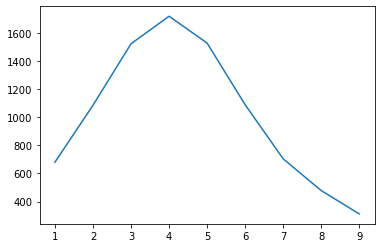

In [87]:
ten = np.arange(1,10,1)
five = np.arange(1,5,1)
plt.plot(ten,phodf.iloc[505,0:9])

In [137]:
phodf

,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
0,341,516,901,1742,2847,2977,1846,948,554,326,...,1509,1374,1078,744,483,602,663,824,890,841
1,361,497,701,950,1232,1272,1175,905,681,472,...,3553,1831,913,453,245,708,694,666,614,469
2,202,278,380,447,613,710,826,852,732,619,...,483,180,92,57,27,475,453,422,415,350
3,492,1204,3403,6592,2896,1061,424,244,128,96,...,904,1015,1032,913,714,534,731,1056,1428,1470
4,256,762,3331,14226,2368,583,220,110,71,39,...,783,918,910,778,664,405,624,938,1289,1536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,266,382,518,713,964,1215,1219,1021,883,587,...,2490,979,505,281,154,564,590,516,480,433
996,792,2356,7203,4736,1429,555,284,140,97,52,...,692,955,979,968,833,478,781,1191,1688,1956
997,633,896,1145,1285,1119,918,666,500,342,256,...,2061,4017,3873,1873,881,1209,1475,1363,1010,776
998,449,639,769,925,1053,911,794,631,425,328,...,5206,6239,2069,775,371,1018,964,888,707,563
